## Load all the things and files

In [11]:
#This notebook is used to quickly visualize the massive star simulation
from yt.config import ytcfg
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import yt
import glob
import math
from matplotlib import cm
from yt.units.yt_array import YTArray
from mpl_toolkits.axes_grid1 import AxesGrid
from palettable.colorbrewer.sequential import PuBuGn_9
from palettable.cubehelix import classic_16, perceptual_rainbow_16, cubehelix1_16, cubehelix2_16 
from palettable.cubehelix import cubehelix3_16,jim_special_16, red_16,purple_16
from palettable.colorbrewer.diverging import Spectral_10
from palettable.cartocolors.diverging import TealRose_7
from palettable.cmocean.diverging import Curl_11, Curl_20 
import matplotlib.colorbar as cbar
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import msFields
#from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u
from yt.fields.api import ValidateParameter
from yt.utilities.exceptions import YTFieldNotFound
from yt.fields.api import ValidateParameter


MSUN = 1.989e33
RSUN=6.96e10
PCCM = 3.08567758e18
AUCM = 1.49597871e13
kAUCM =1e3*AUCM
G=6.67e-8
GAMMA=1.666667
KB = 1.3806488e-16
MU=2.33*1.67e-24
CSOL=2.99792458e10
SIGMA= 5.670373e-5
ARAD= 4*SIGMA/CSOL
SECYR=3600*24.*365.25

Rc = 0.1*PCCM
Mc=150*MSUN
rho = (3*Mc)/(4*math.pi*Rc**3.)
#tff = ((3*math.pi)/(32.*G*rho))**0.5
krho = 1.5
ri = 9.64274242e15
denom = (4.0/3.0)*math.pi * ri**3. * (Rc/ri)**krho
denom = denom + (4.0*math.pi* Rc**3.0) / (3. - krho)*(1.0 - (ri/Rc)**(3.-krho))
rho_edge = Mc / denom;
tff_edge = ((3*math.pi)/(32.*G*rho_edge))**0.5
tff = ((3*math.pi)/(32.*G*rho))**0.5
mmin = 0.04*MSUN

#yt.enable_plugins()
figpath = '/zang/rosen/paper_figures/msfOFpaper/'
fpath_MSF = '/Users/anna/Dropbox/PostDocLife/ORION_data/TURB_OFpaper_Lev5/'
fstrs = ['TURB_Lev5/','TURB_OUTFLOWS_Lev5/', 'TURB_OFB_Lev5/']
figpath = '/Users/anna/Dropbox/Apps/Overleaf/OrionPapers/HMSF_Outflows/figures/'
datapath = fpath_MSF+ 'analysisData/'
#Get colormaps
viridis_cm = plt.get_cmap('viridis')
inferno_cm = plt.get_cmap('inferno')


#Same times
filesTime = [#RadOnly Files
            fpath_MSF+fstrs[0]+'TIME/data.0406.3d.hdf5',
            fpath_MSF+fstrs[0]+'TIME/data.0677.3d.hdf5',
             fpath_MSF+fstrs[0]+'TIME/data.0880.3d.hdf5',
             fpath_MSF+fstrs[0]+'TIME/data.1025.3d.hdf5',
             fpath_MSF+fstrs[0]+'TIME/data.1163.3d.hdf5',
             #OF files
             fpath_MSF+fstrs[1]+'data.0505.3d.hdf5',
             fpath_MSF+fstrs[1]+'data.0768.3d.hdf5',
            fpath_MSF+fstrs[1]+'data.0966.3d.hdf5',
             fpath_MSF+fstrs[1]+'data.1106.3d.hdf5',
            fpath_MSF+fstrs[1]+'data.1238.3d.hdf5',
            #OFB files
        fpath_MSF+fstrs[2]+'TIME/data.0150.3d.hdf5',
        fpath_MSF+fstrs[2]+'TIME/data.0420.3d.hdf5',
        fpath_MSF+fstrs[2]+'TIME/data.0620.3d.hdf5',
        fpath_MSF+fstrs[2]+'TIME/data.0750.3d.hdf5',
        fpath_MSF+fstrs[2]+'TIME/data.0890.3d.hdf5']
#same mass
files = [#RadOnly Files
        fpath_MSF+fstrs[0]+'data.0286.3d.hdf5',
        fpath_MSF+fstrs[0]+'data.0539.3d.hdf5',
         fpath_MSF+fstrs[0]+'data.0720.3d.hdf5',
         fpath_MSF+fstrs[0]+'data.0758.3d.hdf5',
         fpath_MSF+fstrs[0]+'data.0781.3d.hdf5',
         #OF files
         fpath_MSF+fstrs[1]+'data.0505.3d.hdf5',
         fpath_MSF+fstrs[1]+'data.0768.3d.hdf5',
        fpath_MSF+fstrs[1]+'data.0966.3d.hdf5',
         fpath_MSF+fstrs[1]+'data.1106.3d.hdf5',
        fpath_MSF+fstrs[1]+'data.1238.3d.hdf5',
        #OFB files
        fpath_MSF+fstrs[2]+'data.0183.3d.hdf5',
        fpath_MSF+fstrs[2]+'data.0489.3d.hdf5',
        fpath_MSF+fstrs[2]+'data.0964.3d.hdf5',
        fpath_MSF+fstrs[2]+'data.1324.3d.hdf5',
        fpath_MSF+fstrs[2]+'data.1435.3d.hdf5']
#Only the runs with outflows
filesOF = files[5:]

nfiles = len(files)
ndata = int(nfiles/3)
msmin = 0.1 #min stellar mass to plot
msmax = 53. #max stellar mass size



#Functions here
#Assume star's angular momentum vector is the new zhat-direction
# that means the angle between L and zhat is given by \theta =arccos(jz) where jz is the third component of L
def getPerpVecs(k):
    x = np.random.randn(3) # take a random vector
    x -= x.dot(k) * k # make it orthogonal to k
    x /= np.linalg.norm(x) # normalize it
    y = np.cross(k, x) # get 2nd vector
    y /= np.linalg.norm(y) # normalize it
    
    return(x,y)

def gramSchmidt(x1):
    v1 = x1
    x2 = np.array([0,1,0])
    x3 = np.array([0,0,1])
    v2 = x2 - (x2.dot(v1))/(v1.dot(v1))*v1
    
    v3 = x3 - (x3.dot(v1))/(v1.dot(v1))*v1 - (x3.dot(v2))/(v2.dot(v2))*v2
    v2 = v2/np.sqrt(v2.dot(v2))
    
    v3 = v3/np.sqrt(v3.dot(v3))
    return(v2, v3)

#Get new positions for stars given set of vectors
# do this on a dataset by dataset basis

def transformPosition(xphat, yphat, zphat, partPos, partMass, cstar, msmin):
    npartPos = np.zeros(partPos.shape)
    w = np.where(partMass == partMass.max())
    
    xhat = np.array([1,0,0])
    yhat = np.array([0,1,0])
    zhat = np.array([0,0,1])
    #xvec = . transArr0.dot(xvec') 
    transArr0 = np.array([[xhat.dot(xphat), xhat.dot(yphat), xhat.dot(zphat)], 
                         [yhat.dot(xphat), yhat.dot(yphat), yhat.dot(zphat)],
                         [zhat.dot(xphat), zhat.dot(yphat), zhat.dot(zphat)]])
    #Get inverse of array
    #xvec' = . rotationArr.dot(xvec)
    rotationArr = np.linalg.inv(transArr0)

    for i in range(len(partPos)):
        if (partMass[i] <msmin or i == w[0][0]):
             npartPos[i] = np.array([np.nan,np.nan,np.nan])
        else:
            pos = partPos[i]-centeri
            npartPos[i] = rotationArr.dot(pos)    
    return npartPos
    
def transformPosition2(L1, L2, L3, partPos, partMass, cstar, msminp):
    npartPos = np.zeros(partPos.shape)
    w = np.where(partMass == partMass.max())
    if (cstar == True):
        centeri = partPos[w[0][0]] 
    else:
        centeri = [0,0,0]        
    Larr=np.transpose(np.array([L3,L2,L1]))
    #Larr=np.array([L3,L2,L1])
    for i in range(len(partPos)):
        if (partMass[i] <msminp):
            npartPos[i] = np.array([np.nan,np.nan,np.nan])
        else:
            pos = partPos[i]-centeri
            npartPos[i] = Larr.dot(pos)
    return npartPos

## New yt fields

In [15]:
#new yt fields
from yt.fields.api import ValidateParameter
def _cloud_density(field,data):
    rho = data['density'].v
    frac = data['tracer1'].v/rho
    rho[frac<1e-6] = 0
    return rho
yt.add_field("cloud_density", function=_cloud_density, units=None, sampling_type="local", force_override=True, take_log =True)

def _trFrac(field,data):
    rho = data['density'].v
    frac = data['tracer1']/rho
    frac[frac<1e-3] = 0
    return(frac)
yt.add_field("trFrac", function=_trFrac, units='dimensionless', sampling_type="local", force_override=True)


def _myRadialVelocity(field,data):
    if data.has_field_parameter("bulk_velocity"):
        bv = data.get_field_parameter("bulk_velocity").in_units("cm/s")
    else:
        bv = data.ds.arr(np.zeros(3), "cm/s")
    xv = data["velocity_x"] - bv[0]
    yv = data["velocity_y"] - bv[1]
    zv = data["velocity_z"] - bv[2]
    if data.has_field_parameter("bulk_velocity"):
        center = data.get_field_parameter('center')
    else:
        center = data.ds.arr(np.zeros(3), "cm")
    x_hat = data["x"] - center[0]
    y_hat = data["y"] - center[1]
    z_hat = data["z"] - center[2]
    r = np.sqrt(x_hat*x_hat+y_hat*y_hat+z_hat*z_hat)
    x_hat /= r
    y_hat /= r
    z_hat /= r
    return(xv*x_hat + yv*y_hat + zv*z_hat)
yt.add_field("my_radial_velocity", function=_myRadialVelocity, units='cm/s', sampling_type="local",
             validators=[ValidateParameter('center'),
                         ValidateParameter('bulk_velocity')], force_override=True)



def _rhovr(field,data):
    return(data['cloud_density']*data['my_radial_velocity'].v)
    #return(data['density'].v*data['my_radial_velocity'].v)
yt.add_field("my_rhovr", function=_rhovr, units=None, sampling_type="local", force_override=True, take_log = True)

def _wind_density(field,data):
    try:
        tr2 = data['tracer2'].v
    except YTFieldNotFound:
        tr2 = data['tracer1'].v
    rho_min = data['density'].min()
    tr2[tr2<rho_min.v] = 0
    return tr2
yt.add_field("wind_density", function=_wind_density, units=None, sampling_type="local", force_override=True, take_log =True)

def _outflow_Frac(field,data):
    try:
        trFracRatio = data['tracer2'].v/data["gas", "density"].v
        trFrac = data.get_field_parameter("trFrac")
        if trFrac is None:
            # use a default if unset
            trFrac = yt.YTArray(0.1, None)
        wind = data['tracer2']
        wind[trFracRatio < trFrac] = 0
    except YTFieldNotFound:
        trFracRatio=data['tracer1']
    return(wind)

def _entrained_density(field,data):
    minWind = 0.05 #cells that contain 5% of wind density
    windRho = data['wind_density']
    rho = data['cloud_density']
    windFrac = windRho/rho
    center = data.get_field_parameter('center')
    vrad = data['my_radial_velocity'].v
    outFlowRho = rho-windRho
    outFlowRho[windFrac<minWind] = 0
    outFlowRho[outFlowRho<0] = 0
    outFlowRho[vrad <= 0] = 0
    return outFlowRho
yt.add_field("entrained_density", function=_entrained_density, units=None, sampling_type="local", force_override=True, take_log =True)

def _entrained_temperature(field,data):
    temp =data['temperature']
    rhoEnt = data['entrained_density']
    temp[rhoEnt <= 1e-30] = 0
yt.add_field("entrained_temperature", function=_entrained_density, units='K', sampling_type="local", force_override=True, take_log =False)

# Calculate Wind resolution criteria

In [16]:
Mdotw = 1e-7 #Msun/yr
Mdotw_cgs = 1e-7 *MSUN

## Get star and disk's angular momentum vectors used for plotting

In [17]:
#Get vectors
DOTIME = 0
#vectors depend on angular momentum of gas within sphere of radius
#r from star
Lgf = np.zeros((nfiles,3)) #gas angular momentum vector
Lg2f = np.zeros((nfiles,3)) #vector perp. to L
Lg3f = np.zeros((nfiles,3)) #vector perp. to L

#vectors depend on star's angular momentum vector
Ljf = np.zeros((nfiles,3)) #star's angular momentum vector
Lj2f = np.zeros((nfiles,3)) #vector perp. to L
Lj3f = np.zeros((nfiles,3)) #vector perp. to L

if not(DOTIME):
    ts = yt.DatasetSeries.from_filenames(files)
else:
    ts = yt.DatasetSeries.from_filenames(filesTime)
width= 1000*AUCM
wfac =4

for i,ds in enumerate(ts.piter()):
    ad=ds.all_data()
    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'

    if (ds.index.num_stars>0):
            mstar_t = ad["particle_mass"].v/MSUN
            Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
            title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
            wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
            smax = (ad["particle_mass"].max()).v/MSUN
            pos_xi=ad["particle_position_x"][wm]
            pos_yi= ad["particle_position_y"][wm]
            pos_zi = ad["particle_position_z"][wm]
            centeri = [pos_xi.v, pos_yi.v, pos_zi.v]
            pos_x = ad["particle_position_x"].v - centeri[0]
            pos_y = ad["particle_position_y"].v - centeri[1]
            pos_z = ad["particle_position_z"].v - centeri[2]
            
            #Also get the angular momentum vector
            jmag = (ad['particle_angmomen_x'][wm].v**2.+ad['particle_angmomen_y'][wm].v**2. + \
                    ad['particle_angmomen_z'][wm].v**2)**0.5
            jx = ad['particle_angmomen_x'][wm].v/jmag
            jy = ad['particle_angmomen_y'][wm].v/jmag
            jz = ad['particle_angmomen_z'][wm].v/jmag

            sp = ds.sphere(centeri, width/wfac)
            #Get angular momentum vector of disk
            Ls = sp.quantities.angular_momentum_vector(use_particles = False)
            Lg = Ls/np.linalg.norm(Ls)
            Lj = np.array([jx,jy,jz])
            if (Lg[2] < 0):
                Lg = -1.*Lg
            if (Lj[2] < 0):
                Lj = -1.*Lj
            
            Lgf[i,:] = Lg
            Ljf[i,:] = Lj
            
            #L = np.array([0,0,1])
            L2hold, L3hold = gramSchmidt(Lgf[i,:])
            Lg2f[i,:] = L2hold
            Lg3f[i,:] = L3hold
            
            L2hold, L3hold = gramSchmidt(Ljf[i,:])
            Lj2f[i,:] = L2hold
            Lj3f[i,:] = L3hold

print('L:')
print(Lgf)

print('L2:')
print(Lg2f)

print('L3:')
print(Lg3f)
            
print('Star L:')
print(Ljf)

print('Star L2:')
print(Lj2f)

print('Star L3:')
print(Lj3f)

AttributeError: type object 'DatasetSeries' has no attribute 'from_filenames'

In [18]:
#Fedd and density slice plots
textargs = {'color':'w', 'horizontalalignment':'left', 'size':'10'}
boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'black', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}

fig = plt.figure()
fig.set_size_inches(15, 12, forward=True)
ncol = 6
nrow = 5

DO_Fedd = 1

v_max = 1e7
v_min = 1e4
rhomin = 5e-20
BIG = 1
DOX = 0
rho_lim = YTArray([1e-21, 1e-14], 'g/cm**3')
T_lim = YTArray([1e-9, 1e-2], 'erg/cm**3')
cbar_lab = r'$\rm{Density \;[g\,cm^{-3}]}$'
    
if not(DO_Fedd):        
    field2 = 'radiation-energy-density'
    T_lim = YTArray([1e-10, 1e-3], 'dimensionless')
else:
    field2 = 'fedd'
    T_lim = YTArray([1e-1, 100], 'dimensionless')
field1 = 'cloud_density'
xmar=[0.1, 0.25]
ymar = [0.3,0.3]


if BIG:
    fign1 = 'TurbOF_All_Density_fedd_multipanel'
    wfac = 0.175
else:
    fign1 = 'TurbOF_All_Density_fedd_multipanel_small'
    wfac = 0.05
        
#cbar_lab = r'$\rm{\Sigma \;[g\,cm^{-2}]}$'
#cm = jim_special_16.mpl_colormap
cm = viridis_cm
cmT = classic_16.mpl_colormap #matplotlib.cm.get_cmap('PiYG_r')
cms = perceptual_rainbow_16.mpl_colormap
cmap = matplotlib.cm.get_cmap(cms)

#stuff for quiver vectors
qscale=30
qwidth=0.004
qhw=3
qhl=3
narrow=32
narrow2=32

#rect_g = (0.01,0.01,1,2./3.)
#rect = l,b,w,h
rect_g = (0.01,0.01,0.8,1)
grid = AxesGrid(fig, rect_g,
                nrows_ncols = (nrow, ncol),
                direction = "column",
                axes_pad = 0.05,
                label_mode = "L",
                share_all = False,
                cbar_location="right",
                cbar_mode="None",
                cbar_size="5%",
                cbar_pad="10%")
#normp=colors.LogNorm(vmin=msmin, vmax=msmax)
normp = colors.Normalize(vmin=msmin,vmax=msmax)
ts = yt.DatasetSeries.from_filenames(files)
for i,ds in enumerate(ts.piter()):
    #ds.add_field("cloud_density", function=msFields._cloud_density, units=None, take_log=True)
    if (DO_Fedd):
        #Add gradient fields to make frad and fgrav
        gradphi = ds.add_gradient_fields(('chombo', u'gravitational-potential'))
        grader = ds.add_gradient_fields(('chombo', u'radiation-energy-density'))
        #Add fields 
        ds.add_field("kappar_semenov", function=msFields._kappar_semenov,units=None, take_log=False)
        ds.add_field("flux_limiter", function=msFields._fluxLimiter,units=None, take_log=True)
        ds.add_field("fraddiff", function=msFields._fraddiff, units=None, take_log=True)
        ds.add_field("fraddr", function=msFields._fraddr, units=None, take_log=True)
        ds.add_field("fradtot", function=msFields._fradtot, units=None, take_log=True)
        ds.add_field("fgravmag", function=msFields._fgravmag, units=None, take_log=True)
        ds.add_field("fedd", function=msFields._fedd, units=None, take_log=True)
    
    if (i < nrow):
        rho_col = 0
        T_col = 3
    elif (i < 2*nrow):
        rho_col = 1
        T_col = 4
    else:
        rho_col = 2
        T_col = 5
    
    irow = i%nrow
    irho = (nrow*rho_col) + irow
    iT = (nrow*T_col) + irow
    
    print('%s, i = %s, rho_col = %s, T_col = %s, irow = %s, irho = %s, iT = %s' %(ds, i, rho_col, T_col, irow, irho, iT))
    ad=ds.all_data()
    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'

    if (ds.index.num_stars>0):
        mstar_t = ad["particle_mass"].v/MSUN
        Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
        title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
        wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
        pos_xi=ad["particle_position_x"][wm]
        pos_yi= ad["particle_position_y"][wm]
        pos_zi = ad["particle_position_z"][wm]
        centeri = np.asarray([pos_xi.v, pos_yi.v, pos_zi.v]) 
    else:
        centeri = np.asarray([0,0,0])
    
    if DOX:
        L = [0,0,1]
        L2 = [1,0,0]
    else:
        L = Ljf[i,:]
        L2 = Lj2f[i,:]
            
    #Get cutting plane
    cutting = ds.cutting(L2, centeri, north_vector = L)
    domain = ds.domain_width[0].v
    fac = wfac*PCCM/domain
    frb = yt.FixedResolutionBuffer(cutting, (-fac*domain, fac*domain, -fac*domain, fac*domain),(1024,1024))
            
    slc_rho = frb["density"].v
    slc_fedd = frb[field2].v
    
    extent = [2*ds.domain_left_edge[1].v*fac/kAUCM,\
                2*ds.domain_right_edge[1].v*fac/kAUCM,\
                2*ds.domain_left_edge[2].v*fac/kAUCM,\
                2*ds.domain_right_edge[2].v*fac/kAUCM]
    
    
    vx_arr = frb['cutting_plane_velocity_x'].v
    vy_arr = frb['cutting_plane_velocity_y'].v

    vtot_arr = (vx_arr**2.+vy_arr**2.)**0.5
    vx= np.ma.array(vx_arr)
    vx[slc_rho < rhomin] = np.ma.masked
    vx[vx==0] = np.ma.masked
    vy= np.ma.array(vy_arr)
    vy[slc_rho < rhomin] = np.ma.masked
    vy[vy==0] = np.ma.masked
    vtot = np.ma.array(vtot_arr)
    vx[vtot>v_max] = np.ma.masked
    vy[vtot>v_max] = np.ma.masked
    vtot[slc_rho < rhomin] = np.ma.masked
    vtot[vtot==0] = np.ma.masked
    
    #Get dy and dz, ny, nz
    dx = 2*ds.domain_width[0].v/(1024)
    dy = 2*fac*ds.domain_width[1].v/(1024)
    dz = 2*fac*ds.domain_width[2].v/(1024)
    nx = 1024
    ny = 1024
    nz = 1024
    skip=int(nx/narrow)
    skip2=int(nx/narrow2)
    
    xvec=extent[0]+(np.arange(0,ny,skip))*dy/kAUCM + 0.5*dy/kAUCM   #AJC
    yvec=extent[2]+(np.arange(0,nz,skip))*dz/kAUCM + 0.5*dz/kAUCM #AJC
    vxsub=vx[int(skip/2):-1:skip,int(skip/2):-1:skip]/1.
    vysub=vy[int(skip/2):-1:skip,int(skip/2):-1:skip]/1.
    vtotsub=vtot[int(skip/2):-1:skip,int(skip/2):-1:skip]/1.
    sfac=1e5
    uu = np.sqrt(np.abs(vxsub)/sfac)
    uu[vxsub<0] = -1*np.sqrt(np.abs(vxsub[vxsub<0])/sfac)
    vv = np.sqrt(np.abs(vysub)/sfac)
    vv[vysub<0] = -1*np.sqrt(np.abs(vysub[vysub<0])/sfac)
    scale = 1
                             
    u = uu
    v = vv
    uv = vtotsub
    
    uv_mag = np.sqrt(vxsub**2.+vysub**2.)
    
    im = grid[irho].imshow(np.clip(slc_rho, rho_lim[0].v, rho_lim[1].v), \
                            aspect = None, origin='lower', extent = extent, \
                            norm = LogNorm(), cmap = cm)
    #q1 = grid[irho].quiver(xvec, yvec, u/uv_mag, v/uv_mag, \
                           #scale=qscale, angles='xy', width=qwidth, \
                           #headwidth=qhw, headlength=qhl)
    q1 = grid[irho].quiver(xvec, yvec, u, v, angles='uv', scale = scale, scale_units = 'x')
    
    im = grid[iT].imshow(np.clip(slc_fedd, T_lim[0].v, T_lim[1].v), \
                         aspect = None, origin='lower', extent = extent, \
                         norm = LogNorm(), cmap = cmT)
    
    grid[irho].get_xaxis().set_ticks([])
    grid[irho].get_yaxis().set_ticks([])
    grid[iT].get_xaxis().set_ticks([])
    grid[iT].get_yaxis().set_ticks([])
    
    #Add text
    #if (irho<nrow*3):
    grid[irho].text(0.02,0.98,title1, fontsize=10, color = 'White',
                    horizontalalignment='left', verticalalignment='top',
                    transform=grid[irho].transAxes)
        
    grid[irho].text(0.02, 0.0,title2, fontsize=10, color = 'White',
                    horizontalalignment='left', verticalalignment='bottom',
                    transform=grid[irho].transAxes)
    #elif (i<2*nrow and i>=nrow):
        #grid[irho].text(0.02, 0.0,title2, fontsize=10, color = 'White',
        #                horizontalalignment='left', verticalalignment='bottom',
        #                transform=grid[irho].transAxes)
        
            
offset = 0.01
cbarwidth=0.025
cbaroff=0.0105
#rect = l,b,w,h
#offsetx = 0.11
offsetx = 0.1 #0.13
hfac = 0.8 #0.78
boffset = 0.09#0.11
fig.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,\
                    right=0.99,bottom=0.01,top=0.99)

rect_c1 = [rect_g[2]+0.02+offsetx,rect_g[1]+boffset, cbarwidth,rect_g[3]*hfac]
rect_c2 = [rect_g[2]+offsetx,rect_g[1]+boffset, cbarwidth,rect_g[3]*hfac]
axcbar1=fig.add_axes(rect_c1, label='cbar1')
axcbar2=fig.add_axes(rect_c2, label='cbar2')
norm1=colors.LogNorm(vmin=rho_lim[0].v, vmax=rho_lim[1].v)
cbar.ColorbarBase(axcbar1, norm=norm1, orientation='vertical', 
                              cmap = cm)
norm2=colors.LogNorm(vmin=T_lim[0].v, vmax=T_lim[1].v)
cbar.ColorbarBase(axcbar2, norm=norm2, orientation='vertical', 
                              cmap = cmT)

plt.setp(axcbar1.get_yticklabels(), fontsize=14)
axcbar1.set_ylabel(cbar_lab, fontsize=16)
axcbar2.set_ylabel(r'$\rm f_{\rm Edd}$', fontsize=16)
axcbar2.yaxis.set_ticks_position('left')
axcbar2.yaxis.set_label_position('left')
plt.setp(axcbar2.get_yticklabels(), fontsize=14)
plt.savefig(figpath + fign1 + '.pdf', bbox_inches='tight')
plt.savefig(figpath + fign1 + '.png', bbox_inches='tight')
plt.show()

/var/folders/g4/b3gtnddx08d461bc9l775lnr0000gn/T/ipykernel_53594/2071671551.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cms)


ValueError: 'None' is not a valid value for cbar_mode; supported values are 'each', 'single', 'edge', None

<Figure size 1500x1200 with 0 Axes>

## Script to make ram pressure, f_edd, and density slices and projections for paper

In [6]:
#Comment
from yt.fields.api import ValidateParameter
DOLAST=0

BIG = 0
JSTAR = 0
JGAS = 1
KAUD = 0
PLOTV = 0
DOLAST = 0
DODISK = 0
#Make directrad rho*vr thin projection plots (4 columns by two rows, where row 1 = TURB_OF run and row 2 = TURB run)
THIN_PROJ = 0
dovr = 0
DORVR = 0 #Do rho v_r
DORHO = 1 #Density thin projections
DOFRAG = 0
DOFEDD = 0
DOTRACER = 0
fig = plt.figure()
fig.set_size_inches(12, 12, forward=True)

if DORHO or DOFEDD:
    col ='w'
else:
    col = 'k'
if not(DOLAST):
    textargs = {'color': col, 'horizontalalignment':'left', 'size':'11'}
else:
    textargs = {'color': col, 'horizontalalignment':'left', 'size':'18'}
    textargs2 = {'color': col, 'horizontalalignment':'left', 'size':'24', 'weight' : 'heavy'}
boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'white', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}

xmar=[0.1, 0.25]
ymar = [0.3,0.3]
msmin = 0.1 #min stellar mass to plot
msmax = 50. #max stellar mass size
if KAUD:
    depth = 1000*AUCM
    fsd = 'd1000AU'
else:
    depth = 500*AUCM
    fsd = 'd500AU'

if BIG:
    if not(DOFEDD):
        width = 0.4*PCCM
    else:
        width = 0.25*PCCM
    fsw = 'big'
else:
    width = 20000*AUCM
    fsw = 'small'
    
    
if JSTAR:
    #Use L that depends on gas
    Lf = Ljf
    L2f = Lj2f
    L3f = Lj3f
    fsl='_Jstar'
elif JGAS:
    Lf = Lgf
    L2f = Lg2f
    L3f = Lg3f
    fsl = '_Jgas'
else:
    fsl = '_xproj' 
fsa = fsd+fsw+fsl

if dovr:
    field = 'my_radial_velocity'
    field_lim = [-1.0e6,2.0e7]
    fign1 = 'Turb_vrad_Both_multipanel_' + fsa + 'OF.png'
    fign2 = 'Turb_vrad_Both_multipanel_' + fsa + 'OF.pdf'
    cbar_lab = r'$\rm{v_{\rm r} \;[cm \,s^{-1}]}$'
    lint = 1e4 #.1 km/s
    #cm = TealRose_7.mpl_colormap
    cm = plt.get_cmap('BrBG')
    weight = 'density'
elif DORVR:
    field = 'my_rhovr'
    fign1 = 'Turb_rhovr_Both_multipanel_' + fsa + 'OF.png'
    fign2 = 'Turb_rhovr_Both_multipanel_' + fsa + 'OF.pdf'
    cbar_lab = r'$\rm{\rho v_{\rm r} \;[g \, cm^{-2} \,s^{-1}]}$'
    #cm = TealRose_7.mpl_colormap
    cm = Curl_20.mpl_colormap
    weight = 'density'
    if BIG:
        field_lim = [-1e-10,1e-10]
        lint = 1e-16 
    else:
        field_lim = [-1e-9, 1e-9]
        lint = 1e-14
elif DORHO:
    field = 'cloud_density'
    fign1 = 'Turb_density_Both_multipanel_' + fsa + 'OF.png'
    fign2 = 'Turb_density_Both_multipanel_' + fsa + 'OF.pdf'

    cm =  plt.get_cmap('viridis')
    weight = 'density'
    cbar_lab = r'$\rm{Density \; [g \; cm^{-3}]}$'
    if BIG:
        field_lim = [1e-22, 1e-14]
    else:
        field_lim = [1e-19, 1e-13]
    #field_lim = [rho_edge/2e2, 1e-14]
        PLOTV = 1
elif DOFEDD:
    field = 'fedd'
    field_lim = [1e-1, 100]
    weight = 'density'
    cm = classic_16.mpl_colormap
    cbar_lab = r'$f_{\rm Edd}$'
    
fign1 = 'Turb_' + field + '_Both_multipanel_' + fsa + '.png'
fign2 = 'Turb_' +field + '_Both_multipanel_' + fsa + '.pdf'

cms = perceptual_rainbow_16.mpl_colormap
#for stars
cmap = matplotlib.cm.get_cmap(cms)

fac_x=1
fac_y = 1
fac_z=0.1
coord='z'
res=[1024,1024]

dims = [256,256,256]

#rect_g = (0.01,0.01,1,2./3.)
if not(DOLAST):
    rect_g = (0.01,0.01,1,0.6)
    grid = AxesGrid(fig, rect_g,
                    nrows_ncols = (3, 5),
                    axes_pad = 0.05,
                    #axes_pad = 0.05,
                    label_mode = "all",
                    share_all = False,
                    cbar_location="right",
                    cbar_mode="None",
                    cbar_size="5%",
                    cbar_pad="10%")
else:
    rect_g = (0.01,0.01,1,0.5)
    grid = AxesGrid(fig, rect_g,
                    nrows_ncols = (1, 2),
                    axes_pad = 0.05,
                    label_mode = "all",
                    share_all = False,
                    cbar_location="right",
                    cbar_mode="None",
                    cbar_size="5%",
                    cbar_pad="10%")
    fign1 = 'Turb_' + field + '_LastVir_multipanel_' + fsa + '.png'
    fign2 = 'Turb_'+ field + '_LastVir_multipanel_' + fsa + '.pdf'

normp = colors.Normalize(vmin=msmin,vmax=msmax)
if not(DOLAST):
    ts = yt.DatasetSeries.from_filenames(files)
else:
    ts = yt.DatasetSeries.from_filenames(files)
rad = 10000*AUCM
for i,ds in enumerate(ts.piter()):
    
    if (DOFEDD):
        #Add gradient fields to make frad and fgrav
        gradphi = ds.add_gradient_fields(('chombo', u'gravitational-potential'))
        grader = ds.add_gradient_fields(('chombo', u'radiation-energy-density'))
        #Add fields 
        ds.add_field("kappar_semenov", function=msFields._kappar_semenov,units=None, take_log=False)
        ds.add_field("flux_limiter", function=msFields._fluxLimiter,units=None, take_log=True)
        ds.add_field("fraddiff", function=msFields._fraddiff, units=None, take_log=True)
        ds.add_field("fraddr", function=msFields._fraddr, units=None, take_log=True)
        ds.add_field("fradtot", function=msFields._fradtot, units=None, take_log=True)
        ds.add_field("fgravmag", function=msFields._fgravmag, units=None, take_log=True)
        ds.add_field("fedd", function=msFields._fedd, units=None, take_log=True)
    
    ad=ds.all_data()
    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'

    if (ds.index.num_stars>0):
            mstar_t = ad["particle_mass"].v/MSUN
            Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
            title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
            wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
            smax = (ad["particle_mass"].max()).v/MSUN
            pos_xi=ad["particle_position_x"][wm]
            pos_yi= ad["particle_position_y"][wm]
            pos_zi = ad["particle_position_z"][wm]
            centeri = [pos_xi, pos_yi, pos_zi]
            pos_x = ad["particle_position_x"].v - centeri[0].v
            pos_y = ad["particle_position_y"].v - centeri[1].v
            pos_z = ad["particle_position_z"].v - centeri[2].v

    if JGAS or JSTAR:
        L = Lf[i,:]
        L2 = L2f[i,:]
        L3 = L3f[i,:]
    if THIN_PROJ:
        left_corner = ds.domain_left_edge
        right_corner = ds.domain_right_edge
        left_corner[0] = centeri[0].v - 0.5 * depth
        right_corner[0] = centeri[0].v + 0.5 * depth   
        # Create the region
        
        if JGAS or JSTAR:
            region = ds.disk(centeri, L2, 2*width, depth)
            region.set_field_parameter('center', centeri)
            p=yt.OffAxisProjectionPlot(ds,L2, field,data_source=region,width=width, 
                                        weight_field= weight,center=centeri, north_vector = L)
            print('Doing Jstar' + str(L))
        else:
            region = ds.box(left_corner, right_corner)
            region.set_field_parameter('center', centeri)
            p=yt.ProjectionPlot(ds,'x', field,data_source=region,width=width, 
                                    weight_field= weight,center=centeri)
            print('Doing xproj' )

    else:
        #slcx = ds.cutting([0,0,1], center)
        #p=yt.SlicePlot(ds,coord,field,width=width,center=centeri,fontsize=16)
        #p=yt.SlicePlot(ds,'x', field, width=width, center=centeri)
        p=yt.OffAxisSlicePlot(ds,L2, field, width=width, center=centeri, north_vector=L)
        
    if 0:#PLOTV:
        p.annotate_velocity()#plot_args={"headwidth": 2})
           
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes
    
    nsize =150
    ns = len(mstar_t)
    if 0:
        for j in range(ns):
            if mstar_t[j] < msmin:
                mstar_t[j] = 0
            if mstar_t[j] != smax:
                pos_x[j] = np.nan
                pos_y[j] = np.nan
                pos_z[j] = np.nan
        
    pos_ys = []
    pos_zs = []
    msmin = 0.1
    for j in range(ns):
        if mstar_t[j] > msmin and mstar_t[j] < 9:
            pos_ys.append(pos_y)
            pos_zs.append(pos_z)
            
    
    #p.annotate_particles(width = width, p_size = 30, col =  'HotPink', edgecolors = 'k')
    
    p.set_cmap(field,cm)
    p.set_zlim(field, field_lim[0], field_lim[1])
    p.hide_colorbar()
    if dovr or DORVR:
        p.set_log(field, True, linthresh = lint)
    else:
        p.set_log(field, True) 
    p.annotate_text((0.05, 0.075), title1, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)
    p.annotate_text((0.05, 0.925), title2, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)

    if DOLAST:
        p.annotate_text((0.75, 0.925), runLab[i], coord_system='axis',
                    text_args=textargs2, inset_box_args = boxargs)
    if (field == 'cloud_density' or field == 'fedd'):
        p.set_background_color(field, color = 'k')#cm(rho_edge/1e2))
    


    #p.hide_axes()
    p._setup_plots()
    #pos_x = np.random.rand(len(mstar_t))
    #pos_y = np.random.rand(len(mstar_t))
    
    if not(DOFEDD):
        grid[i].axes.scatter(0, 0, marker='o', s=30, c='SlateGray', \
                            edgecolors = 'k', alpha = 0.75)
    
    grid[i].get_xaxis().set_ticks([])
    grid[i].get_yaxis().set_ticks([])
    grid[i].get_xaxis().set_ticks([])
    grid[i].get_yaxis().set_ticks([])
    grid[i].set_xlabel('')
    grid[i].set_ylabel('')
    print('smax = %s Msun'%(smax))
    print(mstar_t)

offset = 0.01
cbarwidth=0.025
cbaroff=0.0105
#rect = l,b,w,h
offsetx = 0.05

fig.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,\
                    right=0.99,bottom=0.01,top=0.99)
#l,b,w,h
rect_c1 = [rect_g[2]+offsetx,rect_g[1], cbarwidth,rect_g[3]]

rect_c2 = [rect_g[2],rect_g[1], cbarwidth,rect_g[3]]

    
#axcbar1=fig.add_axes(rect_c1, label='cbar1')
axcbar1=fig.add_axes(rect_c2, label='cbar1')
if dovr or DORVR:
    norm1=colors.SymLogNorm(vmin=field_lim[0], vmax=field_lim[1], linthresh=lint)#, linscale=0.03)
else:
    norm1=colors.LogNorm(vmin=field_lim[0], vmax=field_lim[1])
cbar.ColorbarBase(axcbar1, norm=norm1, orientation='vertical', cmap = cm)

#cbar.ColorbarBase(axcbar2, norm=normp, orientation='vertical', 
                              #cmap = cms)

plt.setp(axcbar1.get_yticklabels(), fontsize=16)
axcbar1.set_ylabel(cbar_lab, fontsize=16)
#axcbar2.set_ylabel(r'$\rm M_{\star} \; [M_{\odot}]$', fontsize=16)
#axcbar2.yaxis.set_ticks_position('left')
#axcbar2.yaxis.set_label_position('left')

plt.savefig(figpath + fign1, bbox_inches='tight')
plt.savefig(figpath + fign2, bbox_inches='tight')
plt.show()


NameError: name 'AUCM' is not defined

<Figure size 1200x1200 with 0 Axes>

## Disk Plots

In [7]:
#Disk plots for paper
DOLAST=0
#Use L that depends on gas
Lf = Lgf
L2f = Lg2f
L3f = Lg3f
SLICE=1
#Make disk plots (5 columns by two rows, where row 1 = TURB_OF run and row 2 = TURB run)
textargs = {'color':'w', 'horizontalalignment':'left', 'size':'10'}
if DOLAST:
    textargs = {'color':'w', 'horizontalalignment':'left', 'size':'14'}

boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'black', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}

fig = plt.figure()
if not(DOLAST):
    fig.set_size_inches(7, 11, forward=True)
else:
    fig.set_size_inches(2, 2, forward=True)

if not(SLICE):
    rho_lim = YTArray([3, 300], 'g/cm**2')
else:
    rho_lim = YTArray([1e-17, 5e-13], 'g/cm**3')

xmar=[0.1, 0.25]
ymar = [0.3,0.3]

field = 'density'
field_lim = rho_lim
weight = None
#width = (3000,'AU')
width = 2000*AUCM
depth = 1000*AUCM
cbar_lab = r'$\rm{\Sigma \;[g\,cm^{-2}]}$'
cm = jim_special_16.mpl_colormap
cms = perceptual_rainbow_16.mpl_colormap
#for stars
cmap = matplotlib.cm.get_cmap(cms)

if not(DOLAST):
    fign1 = 'Turb_diskThinProj_All_multipanel.png'
    fign2 = 'Turb_diskThinProj_All_multipanel.pdf'
    nfc = 5
    nfr = 3
else:
    fign1 = 'Turb_disk_Both_multipanelMach_Last.png'
    fign2 = 'Turb_disk_Both_multipanelMach_Last.pdf'
    nfc = 1
    nfr = 1
    
if SLICE:
    fign1 = 'Turb_disk_All_multipanel_Slice_Time.png'
    fign2 = 'Turb_disk_All_multipanel_Slice_Time.pdf'
    #cm = 'viridis'
    cbar_lab = r'$\rm{Density \;[g\,cm^{-3}]}$'
fac_x=1
fac_y = 1
fac_z=0.1
coord='z'
res=[1024,1024]
msmin = 0.1
msmax = 4
dims = [256,256,256]
#[left, bottom, width, height] 
#rect_g = (0.01,0.01,1,2./3.)
if not(DOLAST):
    rect_g = (0.01,0.01,1,0.6)
else:
    rect_g = (0.01,0.1,0.6,0.55)
grid = AxesGrid(fig, rect_g,
                nrows_ncols = (nfr, nfc),
                axes_pad = 0.05,
                label_mode = "all",
                share_all = False,
                cbar_location="right",
                cbar_mode="None",
                cbar_size="5%",
                cbar_pad="10%")

normp=colors.LogNorm(vmin=msmin, vmax=msmax)
#normp = colors.LogNorm(vmin=0.04,vmax=5)
#normp = colors.LogNorm(vmin=msmin,vmax=msmax)
if not(DOLAST):
    ts = yt.DatasetSeries.from_filenames(filesTime)
else:
    ts = yt.DatasetSeries.from_filenames(fVirLast[1])

for i,ds in enumerate(ts.piter()):
    ad=ds.all_data()
    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'

    if (ds.index.num_stars>0):
            mstarMax = mstar_t = ad["particle_mass"].max().v/MSUN
            mstar_t = ad["particle_mass"].v/MSUN
            Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
            title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
            wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
            smax = (ad["particle_mass"].max()).v/MSUN
            pos_xi=ad["particle_position_x"][wm]
            pos_yi= ad["particle_position_y"][wm]
            pos_zi = ad["particle_position_z"][wm]
            centeri = [pos_xi.v, pos_yi.v, pos_zi.v]
            pos_x = ad["particle_position_x"].v - centeri[0]
            pos_y = ad["particle_position_y"].v - centeri[1]
            pos_z = ad["particle_position_z"].v - centeri[2]
            
            L = Lgf[i,:]
            L2 = Lg2f[i,:]
            L3 = Lg3f[i,:]
            
            #Only get stars with m>0.04 MSUN
            ws = np.where(mstar_t>0.04)
            starPos = ds.r['particle_position'][ws[0]]
    
    cg = ds.disk(centeri, L, width, depth)
    den=cg[field]
    if not(SLICE):
        p=yt.OffAxisProjectionPlot(ds,L, field,data_source=cg,width=width, 
                                    weight_field=None,center=centeri, north_vector = L2)
    else:
        p=yt.OffAxisSlicePlot(ds,L, field,data_source=cg,width=width, 
                                        center=centeri, north_vector = L2)
        p.annotate_streamlines('cutting_plane_velocity_x', 'cutting_plane_velocity_y', factor = 128, plot_args = {'color':'SlateGray', 'linewidth': 0.5})
        
    #Get transformed particle positions
    normVec = p.data_source.orienter.unit_vectors[2]
    northVec = p.data_source.orienter.unit_vectors[1]
    eastVec = p.data_source.orienter.unit_vectors[0]
    npartPos= transformPosition(eastVec, northVec, normVec, ds.r['particle_position'].v, ds.r['particle_mass'].v, True, msmin)
    #Remove particles that are outside of projected depth
    for ip in range(len(npartPos)):
        if (abs(npartPos[ip,2]) > depth/2.):
            npartPos[ip,0] = np.nan
            npartPos[ip,1] = np.nan
            npartPos[ip,2] = np.nan
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes
    
    nsize =150
    ns = len(mstar_t)
    for j in range(ns):
        if mstar_t[j] < msmin:
            mstar_t[j] = np.nan
        #if mstar_t[j] != smax:
          #  pos_x[j] = np.nan
          #  pos_y[j] = np.nan
          #  pos_z[j] = np.nan
        
    #Make color list:
    cols = []
    for j in range(len(mstar_t)):
        if mstar_t[j] > msmin:
            #nc = norm(mstar_t[j])
            #cols.append(cmap(nc))
            cols.append(cmap(mstar_t[j]))
        else:
            cols.append(0)
    
    p.set_cmap(field,cm)
    p.set_zlim(field,field_lim[0],field_lim[1])
    p.hide_colorbar()
    
    p.annotate_text((0.05, 0.925), title1, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)
    p.annotate_text((0.05, 0.075), title2, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)
    #for ii in range(len(pos_x)):
        #p.annotate_marker((pos_x[ii], pos_y[ii]), coord_system='plot',
                  #plot_args={'color':'blue','s':50})
    p.hide_axes()
    p._setup_plots()

    #massive star
    if not(DOLAST):
        csize = 30
        msize = 30
        #grid[i].axes.scatter(0, 0, marker='*', s=100, c=mstarMax, \
        #                        cmap=cms, edgecolors = 'face', norm=normp, alpha =  1)
    else:
        csize = 50
        msize = 100
    grid[i].axes.scatter(0, 0, marker='o', s=msize, c='Gold', \
                                    edgecolors = 'k', alpha =  1)
        
    #low-mass stars
    grid[i].axes.scatter(npartPos[:,0]/AUCM, npartPos[:,1]/AUCM, marker='o', s=csize, c=mstar_t, \
                            cmap=cms, edgecolors = 'k', norm=normp, alpha =  0.65)
    print('smax = %s Msun'%(smax))
    print(mstar_t)
    


offset = 0.01
cbarwidth=0.025
cbaroff=0.0105
#rect = l,b,w,h
offsetx = 0.15
offsetx2 = 0.125

fig.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,\
                    right=0.99,bottom=0.01,top=0.99)

rect_c1 = [rect_g[2]+offsetx,rect_g[1], cbarwidth,rect_g[3]]
rect_c2 = [rect_g[2]+offsetx2,rect_g[1], cbarwidth,rect_g[3]]
axcbar1=fig.add_axes(rect_c1, label='cbar1')
axcbar2=fig.add_axes(rect_c2, label='cbar2')
norm1=colors.LogNorm(vmin=field_lim[0].v, vmax=field_lim[1].v)
cbar.ColorbarBase(axcbar1, norm=norm1, orientation='vertical', 
                              cmap = cm)
cbar.ColorbarBase(axcbar2, norm=normp, orientation='vertical', 
                              cmap = cms)

plt.setp(axcbar1.get_yticklabels(), fontsize=14)
axcbar1.set_ylabel(cbar_lab, fontsize=16)
axcbar2.set_ylabel(r'$\rm M_{\star} \; [M_{\odot}]$', fontsize=16)
axcbar2.yaxis.set_ticks_position('left')
axcbar2.yaxis.set_label_position('left')
plt.setp(axcbar2.get_yticklabels(), fontsize=14)
plt.savefig(figpath + fign1, bbox_inches='tight')
plt.savefig(figpath + fign2, bbox_inches='tight')
plt.show()

NameError: name 'Lgf' is not defined

yt : [WARNING  ] 2020-04-06 14:19:18,895 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:19:18,896 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:19:18,897 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:19:18,909 Parameters: current_time              = 537020929143.78906
yt : [INFO     ] 2020-04-06 14:19:18,910 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2020-04-06 14:19:18,911 Parameters: domain_left_edge          = [-6.17135516e+17 -6.17135516e+17 -6.17135516e+17]
yt : [INFO     ] 2020-04-06 14:19:18,912 Parameters: domain_right_edge         = [6.17135516e+17 6.17135516e+17 6.17135516e+17]
/Users/anna/miniconda3/lib/python3.6/site-packages/yt/frontends/chombo/data_structures.py:191: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  boxes = f[lev]['boxes'].value
/Users/anna/miniconda3/lib/python3.6/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-

smax = 9.12059131936524 Msun
[0.04039145 9.12059132 0.01632169 0.04775947]


yt : [INFO     ] 2020-04-06 14:20:31,982 Projection completed
yt : [INFO     ] 2020-04-06 14:20:31,984 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:20:31,985 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:20:31,987 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:20:31,988 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:20:31,990 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:20:32,339 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:20:32,340 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:20:32,341 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:20:32,353 Parameters: current_time              = 1009004937203.5753
yt : [INFO     ] 2020-04-06 14:20:32,354 Parameters: domain_dimensions         = [12

smax = 18.435182604296063 Msun
[1.13851854e-01 2.72451785e-03 4.11421404e-02 2.73026934e-01
 2.19463737e-01 1.84351826e+01 1.68364571e-01 5.24516110e-02
 4.38301710e-01 2.54323871e-01 4.34223692e-02 4.61183587e-02]


yt : [INFO     ] 2020-04-06 14:21:32,766 Projection completed
yt : [INFO     ] 2020-04-06 14:21:32,781 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:21:32,783 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:21:32,784 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:21:32,785 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:21:32,788 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:21:33,805 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:21:33,806 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:21:33,807 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:21:33,817 Parameters: current_time              = 1148051409474.7004
yt : [INFO     ] 2020-04-06 14:21:33,818 Parameters: domain_dimensions         = [12

smax = 30.627667462534106 Msun
[ 0.07236682  0.61391173  0.51373335  0.39645925  0.05602995 30.62766746
  0.17850606  0.88222758  0.05350624  0.05424501  1.23730261  0.04698796
  0.04666299]


yt : [INFO     ] 2020-04-06 14:22:35,839 Projection completed
yt : [INFO     ] 2020-04-06 14:22:35,841 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:22:35,842 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:22:35,843 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:22:35,843 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:22:35,846 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:22:36,198 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:22:36,199 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:22:36,200 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:22:36,213 Parameters: current_time              = 1280011422716.311
yt : [INFO     ] 2020-04-06 14:22:36,214 Parameters: domain_dimensions         = [128

smax = 33.41656759272952 Msun
[ 1.31590973  1.08915953  0.05370939 33.41656759  0.19364085  1.00605649
  0.82066146  0.63829444  0.0574607   0.0470799   0.07238398  0.05493309
  0.29918985  0.04666363]


yt : [INFO     ] 2020-04-06 14:23:22,118 Projection completed
yt : [INFO     ] 2020-04-06 14:23:22,119 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:22,122 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:22,124 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:22,125 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:22,127 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:23:23,253 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:23:23,254 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:23:23,254 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:23:23,267 Parameters: current_time              = 578089458675.8733
yt : [INFO     ] 2020-04-06 14:23:23,268 Parameters: domain_dimensions         = [128

smax = 35.22348060535479 Msun
[3.52234806e+01 2.52368411e-01 1.69825620e+00 1.96488092e+00
 1.73692132e+00 1.32568098e+00 1.20769815e+00 5.53686025e-02
 1.49832399e-01 2.54878059e-03 9.87423336e-02 5.39536047e-02
 4.71550406e-02 7.23839851e-02 4.78712921e-01 4.66636550e-02]


yt : [INFO     ] 2020-04-06 14:23:42,075 Projection completed
yt : [INFO     ] 2020-04-06 14:23:42,076 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:42,077 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:42,078 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:42,079 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:23:42,081 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:23:42,440 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:23:42,441 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:23:42,441 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:23:42,453 Parameters: current_time              = 884058715501.1954
yt : [INFO     ] 2020-04-06 14:23:42,454 Parameters: domain_dimensions         = [128

smax = 9.127835522612276 Msun
[9.12783552]


yt : [INFO     ] 2020-04-06 14:24:13,188 Projection completed
yt : [INFO     ] 2020-04-06 14:24:13,189 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:13,189 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:13,190 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:13,191 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:13,197 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:24:13,553 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:24:13,554 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:24:13,554 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:24:13,566 Parameters: current_time              = 1358083751293.8953
yt : [INFO     ] 2020-04-06 14:24:13,567 Parameters: domain_dimensions         = [12

smax = 18.437956414401008 Msun
[18.43795641]


yt : [INFO     ] 2020-04-06 14:24:47,895 Projection completed
yt : [INFO     ] 2020-04-06 14:24:47,896 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:47,898 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:47,899 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:47,900 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:24:47,901 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:24:48,297 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:24:48,298 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:24:48,298 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:24:48,311 Parameters: current_time              = 1719010965562.1863
yt : [INFO     ] 2020-04-06 14:24:48,312 Parameters: domain_dimensions         = [12

smax = 30.62272009915392 Msun
[30.6227201]


yt : [INFO     ] 2020-04-06 14:25:17,528 Projection completed
yt : [INFO     ] 2020-04-06 14:25:17,529 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:17,530 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:17,531 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:17,533 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:17,535 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800
yt : [WARNING  ] 2020-04-06 14:25:18,079 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-06 14:25:18,080 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-06 14:25:18,081 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-06 14:25:18,102 Parameters: current_time              = 1830025264987.9568
yt : [INFO     ] 2020-04-06 14:25:18,103 Parameters: domain_dimensions         = [12

smax = 33.40089046496297 Msun
[33.40089046]


/Users/anna/miniconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: divide by zero encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2020-04-06 14:25:41,453 Projection completed
yt : [INFO     ] 2020-04-06 14:25:41,453 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:41,454 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:41,456 xlim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:41,457 ylim = -617135516000000000.000000 617135516000000000.000000
yt : [INFO     ] 2020-04-06 14:25:41,458 Making a fixed resolution buffer of (('gas', 'entrained_density')) 800 by 800


smax = 33.63504625553377 Msun
[33.63504626]


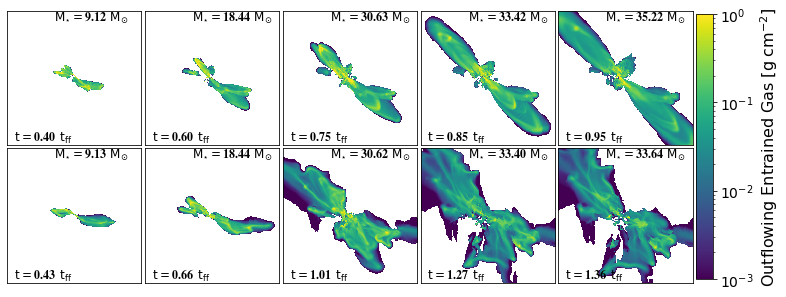

In [8]:
#Mass entrained plots
#Make mass entrained plots (2 rows by ndata columns) for mass that has vrad>0 for the massive star

cm = 'viridis'
SLICE = 0
DOALL = 0
if not(SLICE):
    field_lim = [1e-3, 1]
else:
    field_lim = [1e-20, 1e-14]

#rect_g = (0.01,0.01,1,2./3.)
if not(SLICE):
    field = 'entrained_density'
else:
    field='density'
    
textargs = {'color':'k', 'horizontalalignment':'left', 'size':'12', 'weight' : 'bold'}
boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'white', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}
fig = plt.figure()
fig.set_size_inches(8, 15, forward=True)

rect_g = (0.01,0.01,1,1)
grid = AxesGrid(fig, rect_g,
                nrows_ncols = (2, 5),
                axes_pad = 0.05,
                label_mode = "all",
                share_all = False,
                cbar_location="right",
                cbar_mode=None,
                cbar_size="5%",
                cbar_pad="10%")

ts = yt.DatasetSeries.from_filenames(filesOF)

if not(DOALL):
    fign1 = 'Turb_massEntrainedOut_Both_multipanel_OFB.png'
    fign2 = 'Turb_massEntrainedOut_Both_multipanel_OFB.pdf'
    cbar_lab = r'Outflowing Entrained Gas $\rm [g \; cm^{-2}]$'
else:
    fign1 = 'Turb_massEntrainedAll_Both_multipanel_OFB.png'
    fign2 = 'Turb_massEntrainedAll_Both_multipanel_OFB.pdf'
    cbar_lab = r'All Entrained Gas $\rm [g \; cm^{-2}]$'

mtot0 = 0
DOPLOT =1
for i,ds in enumerate(ts.piter()): 
    ad=ds.all_data()

    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'
    if (ds.index.num_stars>0):
        mstar_t = ad["particle_mass"].v/MSUN
        Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
        title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
        wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
        smax = (ad["particle_mass"].max()).v/MSUN
        pos_xi=ad["particle_position_x"][wm]
        pos_yi= ad["particle_position_y"][wm]
        pos_zi = ad["particle_position_z"][wm]
        centerStar = [pos_xi, pos_yi, pos_zi]
        centeri = [0,0,0]
    else:
        centeri = [0, 0, 0]
        title2 = ''
    reg = ds.region(centeri, ds.domain_left_edge, ds.domain_right_edge)
    reg.set_field_parameter("center", centerStar)
    if not(SLICE):
        p = yt.ProjectionPlot(ds, 0, field, center=centeri, 
                                width=ds.domain_width, data_source=reg)
    else:
        p = yt.SlicePlot(ds, 0, field, center=centeri, 
                                width=ds.domain_width, data_source=reg)
         
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes

    if DOPLOT:
        p.set_cmap(field,cm)
        p.set_zlim(field, field_lim[0], field_lim[1])
        p.hide_colorbar()

    
        p.annotate_text((0.05, 0.025), title1, coord_system='axis',
                            text_args=textargs, inset_box_args = boxargs)#tstar
            
        p.annotate_text((0.35, 0.925), title2, coord_system='axis',
                        text_args=textargs, inset_box_args = boxargs)#Mstar


        
    p._setup_plots()
    
    grid[i].get_xaxis().set_ticks([])
    grid[i].get_yaxis().set_ticks([])
    grid[i].get_xaxis().set_ticks([])
    grid[i].get_yaxis().set_ticks([])
    grid[i].set_xlabel('')
    grid[i].set_ylabel('')   
    print('smax = %s Msun'%(smax))
    print(mstar_t)

if 1:
    offset = 0.01
    cbarwidth=0.025
    cbaroff=0.3
    #rect = l,b,w,h
    offsetx = 0.015

    fig.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,\
                        right=0.99,bottom=0.01,top=0.99)

    rect_c1 = [rect_g[2]+offsetx,rect_g[1]+cbaroff, cbarwidth,rect_g[3]*0.4]
    rect_c2 = [rect_g[2],rect_g[1], cbarwidth,rect_g[3]]
    axcbar1=fig.add_axes(rect_c1, label='cbar1')
    #axcbar1=fig.add_axes(rect_c2, label='cbar1')

    norm1=colors.LogNorm(vmin=field_lim[0], vmax=field_lim[1])
cbar.ColorbarBase(axcbar1, norm=norm1, orientation='vertical') 
                              

plt.setp(axcbar1.get_yticklabels(), fontsize=14)
axcbar1.set_ylabel(cbar_lab, fontsize=16)
#axcbar2.set_ylabel(r'$\rm M_{\star} \; [M_{\odot}]$', fontsize=16)
#axcbar2.yaxis.set_ticks_position('left')
#axcbar2.yaxis.set_label_position('left')

plt.savefig(figpath + fign1, bbox_inches='tight')
plt.savefig(figpath + fign2, bbox_inches='tight')
plt.show()        

In [ ]:
#Make disk plot for B0field only with Magnetic field streamlines overplotted
DOLAST=0
#Use L that depends on gas
Lf = Lgf
L2f = Lg2f
L3f = Lg3f
SLICE=0
#Make disk plots (5 columns by two rows, where row 1 = TURB_OF run and row 2 = TURB run)
textargs = {'color':'w', 'horizontalalignment':'left', 'size':'10'}
if DOLAST:
    textargs = {'color':'w', 'horizontalalignment':'left', 'size':'14'}

boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'black', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}

fig = plt.figure()
if not(DOLAST):
    fig.set_size_inches(7, 11, forward=True)
else:
    fig.set_size_inches(2, 2, forward=True)

if not(SLICE):
    rho_lim = YTArray([3, 300], 'g/cm**2')
else:
    rho_lim = YTArray([1e-17, 5e-13], 'g/cm**3')

xmar=[0.1, 0.25]
ymar = [0.3,0.3]

field = 'density'
field_lim = rho_lim
weight = None
#width = (3000,'AU')
width = 2000*AUCM
depth = 1000*AUCM
cbar_lab = r'$\rm{\Sigma \;[g\,cm^{-2}]}$'
cm = jim_special_16.mpl_colormap
cms = perceptual_rainbow_16.mpl_colormap
#for stars
cmap = matplotlib.cm.get_cmap(cms)

if not(DOLAST):
    fign1 = 'Turb_diskThinProj_All_multipanel.png'
    fign2 = 'Turb_diskThinProj_Bonl_multipanel.pdf'
    nfc = 5
    nfr = 1
else:
    fign1 = 'Turb_disk_Both_multipanelMach_Last.png'
    fign2 = 'Turb_disk_Both_multipanelMach_Last.pdf'
    nfc = 1
    nfr = 1
    
if SLICE:
    fign1 = 'Turb_disk_Bonly_multipanel_Slice.png'
    fign2 = 'Turb_disk_Bonly_multipanel_Slice.pdf'
    #cm = 'viridis'
    cbar_lab = r'$\rm{Density \;[g\,cm^{-3}]}$'
fac_x=1
fac_y = 1
fac_z=0.1
coord='z'
res=[1024,1024]
msmin = 0.1
msmax = 4
dims = [256,256,256]
#[left, bottom, width, height] 
#rect_g = (0.01,0.01,1,2./3.)
if not(DOLAST):
    rect_g = (0.01,0.01,1,0.6)
else:
    rect_g = (0.01,0.1,0.6,0.55)
grid = AxesGrid(fig, rect_g,
                nrows_ncols = (nfr, nfc),
                axes_pad = 0.05,
                label_mode = "all",
                share_all = False,
                cbar_location="right",
                cbar_mode="None",
                cbar_size="5%",
                cbar_pad="10%")

normp=colors.LogNorm(vmin=msmin, vmax=msmax)
#normp = colors.LogNorm(vmin=0.04,vmax=5)
#normp = colors.LogNorm(vmin=msmin,vmax=msmax)
if not(DOLAST):
    ts = yt.DatasetSeries.from_filenames(files[10:])
else:
    ts = yt.DatasetSeries.from_filenames(fVirLast[1])

for i,ds in enumerate(ts.piter()):
    ad=ds.all_data()
    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'

    if (ds.index.num_stars>0):
            mstarMax = mstar_t = ad["particle_mass"].max().v/MSUN
            mstar_t = ad["particle_mass"].v/MSUN
            Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
            title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
            wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
            smax = (ad["particle_mass"].max()).v/MSUN
            pos_xi=ad["particle_position_x"][wm]
            pos_yi= ad["particle_position_y"][wm]
            pos_zi = ad["particle_position_z"][wm]
            centeri = [pos_xi.v, pos_yi.v, pos_zi.v]
            pos_x = ad["particle_position_x"].v - centeri[0]
            pos_y = ad["particle_position_y"].v - centeri[1]
            pos_z = ad["particle_position_z"].v - centeri[2]
            
            L = Lgf[i,:]
            L2 = Lg2f[i,:]
            L3 = Lg3f[i,:]
            
            #Only get stars with m>0.04 MSUN
            ws = np.where(mstar_t>0.04)
            starPos = ds.r['particle_position'][ws[0]]
    
    cg = ds.disk(centeri, L, width, depth)
    den=cg[field]
    if not(SLICE):
        p=yt.OffAxisProjectionPlot(ds,L, field,data_source=cg,width=width, 
                                    weight_field=None,center=centeri, north_vector = L2)
    else:
        p=yt.OffAxisSlicePlot(ds,L, field,data_source=cg,width=width, 
                                        center=centeri, north_vector = L2)
        p.annotate_streamlines('velocity_x', 'velocity_y', factor = 128, plot_args = {'color':'SlateGray', 'linewidth': 0.5})
        
    #Get transformed particle positions
    normVec = p.data_source.orienter.unit_vectors[2]
    northVec = p.data_source.orienter.unit_vectors[1]
    eastVec = p.data_source.orienter.unit_vectors[0]
    npartPos= transformPosition(eastVec, northVec, normVec, ds.r['particle_position'].v, ds.r['particle_mass'].v, True, msmin)
    #Remove particles that are outside of projected depth
    for ip in range(len(npartPos)):
        if (abs(npartPos[ip,2]) > depth/2.):
            npartPos[ip,0] = np.nan
            npartPos[ip,1] = np.nan
            npartPos[ip,2] = np.nan
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes
    
    nsize =150
    ns = len(mstar_t)
    for j in range(ns):
        if mstar_t[j] < msmin:
            mstar_t[j] = np.nan
        #if mstar_t[j] != smax:
          #  pos_x[j] = np.nan
          #  pos_y[j] = np.nan
          #  pos_z[j] = np.nan
        
    #Make color list:
    cols = []
    for j in range(len(mstar_t)):
        if mstar_t[j] > msmin:
            #nc = norm(mstar_t[j])
            #cols.append(cmap(nc))
            cols.append(cmap(mstar_t[j]))
        else:
            cols.append(0)
    
    p.set_cmap(field,cm)
    p.set_zlim(field,field_lim[0],field_lim[1])
    p.hide_colorbar()
    
    p.annotate_text((0.05, 0.925), title1, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)
    p.annotate_text((0.05, 0.075), title2, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)
    #for ii in range(len(pos_x)):
        #p.annotate_marker((pos_x[ii], pos_y[ii]), coord_system='plot',
                  #plot_args={'color':'blue','s':50})
    p.hide_axes()
    p._setup_plots()

    #massive star
    if not(DOLAST):
        csize = 30
        msize = 30
        #grid[i].axes.scatter(0, 0, marker='*', s=100, c=mstarMax, \
        #                        cmap=cms, edgecolors = 'face', norm=normp, alpha =  1)
    else:
        csize = 50
        msize = 100
    grid[i].axes.scatter(0, 0, marker='o', s=msize, c='Gold', \
                                    edgecolors = 'k', alpha =  1)
        
    #low-mass stars
    grid[i].axes.scatter(npartPos[:,0]/AUCM, npartPos[:,1]/AUCM, marker='o', s=csize, c=mstar_t, \
                            cmap=cms, edgecolors = 'k', norm=normp, alpha =  0.65)
    print('smax = %s Msun'%(smax))
    print(mstar_t)
    


offset = 0.01
cbarwidth=0.025
cbaroff=0.0105
#rect = l,b,w,h
offsetx = 0.15
offsetx2 = 0.125

fig.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,\
                    right=0.99,bottom=0.01,top=0.99)

rect_c1 = [rect_g[2]+offsetx,rect_g[1], cbarwidth,rect_g[3]]
rect_c2 = [rect_g[2]+offsetx2,rect_g[1], cbarwidth,rect_g[3]]
axcbar1=fig.add_axes(rect_c1, label='cbar1')
axcbar2=fig.add_axes(rect_c2, label='cbar2')
norm1=colors.LogNorm(vmin=field_lim[0].v, vmax=field_lim[1].v)
cbar.ColorbarBase(axcbar1, norm=norm1, orientation='vertical', 
                              cmap = cm)
cbar.ColorbarBase(axcbar2, norm=normp, orientation='vertical', 
                              cmap = cms)

plt.setp(axcbar1.get_yticklabels(), fontsize=14)
axcbar1.set_ylabel(cbar_lab, fontsize=16)
axcbar2.set_ylabel(r'$\rm M_{\star} \; [M_{\odot}]$', fontsize=16)
axcbar2.yaxis.set_ticks_position('left')
axcbar2.yaxis.set_label_position('left')
plt.setp(axcbar2.get_yticklabels(), fontsize=14)
plt.savefig(figpath + fign1, bbox_inches='tight')
plt.savefig(figpath + fign2, bbox_inches='tight')
plt.show()

In [ ]:
#Make mass entrained plots (2 rows by ndata columns) for mass that has vrad>0 for the massive star
msmax = 36
msmin = 0.1
#for stars
cm = plt.get_cmap('viridis')
SLICE = 1
DOALL = 1

wfs = '05'
wfrac = 0.05
if not(SLICE):
    field_lim = [1e-3, 1]
else:
    field_lim = [1e-20, 1e-14]

#rect_g = (0.01,0.01,1,2./3.)
field = 'entrained_density'
textargs = {'color':'k', 'horizontalalignment':'left', 'size':'12'}#, 'weight' : 'bold'}
boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'white', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}
fig = plt.figure()
fig.set_size_inches(9, 12, forward=True)

width = 0.4*PCCM
rect_g = (0.01,0.01,1,0.2)
grid = AxesGrid(fig, rect_g,
                nrows_ncols = (2, 5),
                axes_pad = 0.05,
                label_mode = "all",
                share_all = False,
                cbar_location="right",
                cbar_mode="None",
                cbar_size="5%",
                cbar_pad="10%")
#normp=colors.LogNorm(vmin=msmin, vmax=msmax)
normp = colors.Normalize(vmin=msmin,vmax=msmax)
ts = yt.DatasetSeries.from_filenames(filesOF)

if not(DOALL):
    fign1 = 'Turb_massEntrainedOut_'+ wfs +'_Adam.png'
    fign2 = 'Turb_massEntrainedOut_'+ wfs +'_Adam.pdf'
    cbar_lab = r'Entrained Gas $\rm $\Sigma(v_r>0) \, [g \; cm^{-2}]$'
else:
    fign1 = 'Turb_massEntrainedAll_'+ wfs +'OFB.png'
    fign2 = 'Turb_massEntrainedAll_'+ wfs +'OFB.pdf'
    cbar_lab = r'Entrained Gas Column Density $\rm [g \; cm^{-2}]$'
    #cbar_lab = r'Entrained $\Sigma \; \rm [g \; cm^{-2}]$'

for i,ds in enumerate(ts.piter()):
    if i == 9:
        continue
    ad=ds.all_data()
    time="%3.2f" % (ds.current_time.v/tff)
    title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'
    if (ds.index.num_stars>0):
        mstar_t = ad["particle_mass"].v/MSUN
        Ms = "%3.2f" %(ad["particle_mass"].max()/MSUN)
        title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'
        wm = np.where(ad['particle_mass'] == ad["particle_mass"].max())[0][0]
        smax = (ad["particle_mass"].max()).v/MSUN
        pos_xi=ad["particle_position_x"][wm]
        pos_yi= ad["particle_position_y"][wm]
        pos_zi = ad["particle_position_z"][wm]
        centeri = [pos_xi, pos_yi, pos_zi]
        pos_x = ad["particle_position_x"].v - centeri[0].v
        pos_y = ad["particle_position_y"].v - centeri[1].v
        pos_z = ad["particle_position_z"].v - centeri[2].v
    else:
        centeri = [0, 0, 0]
        title2 = ''
        
    #centeri = ds.arr(np.zeros(3), 'code_length')
    # First make the left and right corner of the region based
    # on the full domain.
    left_corner = ds.domain_left_edge
    right_corner = ds.domain_right_edge
    
    # Now adjust the size of the region along the line of sight (x axis).
    depth = ds.quan(0.3*PCCM, 'code_length')
    left_corner[1] = centeri[1] - 0.5 * depth
    right_corner[1] = centeri[1] + 0.5 * depth
    left_corner[2] = centeri[2] - 0.5 * depth
    right_corner[2] = centeri[2] + 0.5 * depth

# Create the region
    reg = ds.box(left_corner, right_corner) 
    #reg = ds.region(centeri, left_corner, right_corner)
    reg.set_field_parameter("center", centeri)
    reg.set_field_parameter('wind_frac', wfrac)
    if not(SLICE):
        p = yt.ProjectionPlot(ds, 0, field, center=[0,0,0]) 
                                #width=width#, data_source=reg)
    else:
        p = yt.SlicePlot(ds, 0, field, center=centeri, 
                                width=width, data_source=reg)
         
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes

    p.set_cmap(field,cm)
    p.set_zlim('entrained_density', field_lim[0], field_lim[1])
    p.hide_colorbar()

    
    p.annotate_text((0.05, 0.025), title1, coord_system='axis',
                        text_args=textargs, inset_box_args = boxargs)#tstar
            
    p.annotate_text((0.4, 0.9), title2, coord_system='axis',
                    text_args=textargs, inset_box_args = boxargs)#Mstar
    #p.annotate_marker((0.5, 0.5), marker='*', coord_system='axis',
    #                plot_args={'color':'gray'})
    
    nsize =150
    ns = len(mstar_t)
    msize = np.zeros(ns)
    alphas = np.zeros(ns)
    cols = []
    pos_ys = []
    pos_zs = []
    #print(msize)
    
    for j in range(ns):
        if mstar_t[j] > msmin and mstar_t[j] < 9:
            pos_ys.append(pos_y)
            pos_zs.append(pos_z)
            
    targ = {'size':'12', 'weight' : 'bold'}
    bar_args = {'pad': 0.05, 'sep': 5, 'borderpad': 1, 'color': 'k'}
    #p.annotate_scale(corner='upper_right', coeff=5000, unit='au', text_args= targ, size_bar_args = bar_args, coord_system='axis')
                    #max_frac=0.2, min_frac=0.015, \
                    #coord_system='axis', text_args=textargs)
    p._setup_plots()

    
    #low-mass stars
    if len(pos_ys) > 0:
        grid[i].axes.scatter(np.asarray(pos_ys)/AUCM, np.asarray(pos_zs)/AUCM, marker='o', s=15, \
                                color='HotPink', edgecolors = 'k', alpha =  1)
    #massive star
    grid[i].axes.scatter(0, 0, marker='o', s=30,  \
                            color='SlateGray', edgecolors = 'k', alpha =  0.75)
    
    grid[i].get_xaxis().set_ticks([])
    grid[i].get_yaxis().set_ticks([])
    grid[i].get_xaxis().set_ticks([])
    grid[i].get_yaxis().set_ticks([])
    grid[i].set_xlabel('')
    grid[i].set_ylabel('')   
    print('smax = %s Msun'%(smax))
    print(mstar_t)
    

offset = 0.01
cbarwidth=0.025
cbaroff=0.0105
#rect = l,b,w,h
offsetx = 0.01

fig.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,\
                    right=0.99,bottom=0.01,top=0.99)

rect_c1 = [rect_g[2]+0.02+offsetx,rect_g[1], cbarwidth,rect_g[3]]
rect_c2 = [rect_g[2]+offsetx,rect_g[1], cbarwidth,rect_g[3]]
#axcbar1=fig.add_axes(rect_c1, label='cbar1')
axcbar1=fig.add_axes(rect_c2, label='cbar1')
#if not(DOTRACER):
#    norm1=colors.SymLogNorm(vmin=field_lim[0], vmax=field_lim[1], linthresh=lint)#, linscale=0.03)
#else:
norm1=colors.LogNorm(vmin=field_lim[0], vmax=field_lim[1])
cbar.ColorbarBase(axcbar1, norm=norm1, orientation='vertical', 
                              cmap = cm)
#cbar.ColorbarBase(axcbar2, norm=normp, orientation='vertical', 
                              #cmap = cms)

plt.setp(axcbar1.get_yticklabels(), fontsize=12)
axcbar1.set_ylabel(cbar_lab, fontsize=14)
#axcbar2.set_ylabel(r'$\rm M_{\star} \; [M_{\odot}]$', fontsize=16)
#axcbar2.yaxis.set_ticks_position('left')
#axcbar2.yaxis.set_label_position('left')

plt.savefig(figpath + fign1, bbox_inches='tight')
plt.savefig(figpath + fign2, bbox_inches='tight')
plt.show()        

In [ ]:
#Star data for Mark
sigma = 5.6704e-5
mstar = []
rstar = []
lstar = []
tstar = []

for i,file in enumerate(files):
    #Get the sink file
    sinkFile = file.replace("hdf5", "sink")
    
    data = np.genfromtxt(sinkFile, skip_header = 1)
    if len(data.shape) >1:
        mstarAll = data[:,0]
        rstarAll = data[:,11]
        lstarAll = data[:,-2]
    else:
        mstarAll = data[0]
        rstarAll = data[11]
        lstarAll = data[-2]
        
    tstarAll = (lstarAll/(4*np.pi*rstarAll**2.*sigma))**(0.25)
    if len(data.shape) >1:
        wm =np.where(mstarAll == mstarAll.max())[0][0]
        mstar.append(mstarAll[wm])
        rstar.append(rstarAll[wm])
        lstar.append(lstarAll[wm])
        tstar.append(tstarAll[wm])
    else:
        mstar.append(mstarAll)
        rstar.append(rstarAll)
        lstar.append(lstarAll)
        tstar.append(tstarAll)
    

    
#Save as array
np.save(datapath+'OF_starDataForMark', (np.asarray(mstar), np.asarray(rstar), np.asarray(lstar), np.asarray(tstar) ) )
    
    
    

In [ ]:
sinkData=np.load(datapath+'OF_starDataForMark.npy')

In [ ]:
filesOF

In [ ]:
ds.derived_field_list

In [9]:
#Make last B density plots
textargs = {'color':'w', 'horizontalalignment':'left', 'size':'20'}
textargs2 = {'size':'20'}
boxargs ={'boxstyle':'square', 'pad':0.0, 'facecolor':'black', 'linewidth':0, 'edgecolor':'black', 'alpha':0.0}
DODISK = 1

index = -2 
if DODISK:
    width=(2000, 'au')
    Lnorth = Lg2f[index]
    Lnorm = Lgf[index]
    figname = 'OFB_densityDisk_Bfield'
    coeff = 200
    hidecbar = False
    fload = files[index]
else:
    width=(5000, 'au')
    Lnorth = Lgf[index]
    Lnorm = Lg2f[index]
    figname = 'OFB_densityBubble_Bfield'
    coeff =500
    hidecbar = True
    fload = files[index]

ds=yt.load(fload)
time="%3.2f" % (ds.current_time.v/tff)
title1 = r'$\rm{t=}$'+ time + r' $\rm{\,t_{ff}}$'

if (ds.index.num_stars>0):
    mstar_t = ds.r["particle_mass"].v/MSUN
    Ms = "%3.2f" %(ds.r["particle_mass"].max()/MSUN)
    title2 = r'$\rm{M_{\star}=}$' + Ms + r'$\, \rm{\,M_{\odot}}$'

center=ds.r['particle_position'][0]

slc=yt.OffAxisSlicePlot(ds, Lnorm, 'density',center=center, width=width, north_vector=Lnorth)
slc.annotate_magnetic_field(scale=None, scale_units=None, normalize=False,
                           plotargs=None)
slc.annotate_marker((0.5, 0.5), coord_system='axis', marker = 'o', plot_args={'color':'SlateGray'})
slc.annotate_text((0.025, 0.95), title1, coord_system='axis', inset_box_args = boxargs, text_args=textargs)#,
                    #text_args=textargs, inset_box_args = boxargs)
slc.annotate_text((0.025, 0.05), title2, coord_system='axis', inset_box_args = boxargs, text_args=textargs)

slc.annotate_scale(corner='lower_right', coeff=coeff, unit='au', pos=None)#, inset_box_args = boxargs, text_args=textargs2)
               #scale_text_format="{scale} {units}", max_frac=0.16, min_frac=0.015, coord_system='axis', 
               #text_args=None, size_bar_args=None, draw_inset_box=False, inset_box_args=None)
slc.hide_axes()
#if not(DODISK):
#    slc.hide_colorbar()
    
slc.set_zlim('density', 1e-19,1e-13)

slc.show()
slc.save(figpath+figname+'.pdf')
slc.save(figpath+figname+'.png')

yt : [WARNING  ] 2020-04-15 15:48:32,667 Setting code length unit to be 1.0 cm
yt : [WARNING  ] 2020-04-15 15:48:32,668 Setting code mass unit to be 1.0 g
yt : [WARNING  ] 2020-04-15 15:48:32,668 Setting code time unit to be 1.0 s
yt : [INFO     ] 2020-04-15 15:48:32,688 Parameters: current_time              = 1719010965562.1863
yt : [INFO     ] 2020-04-15 15:48:32,689 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2020-04-15 15:48:32,691 Parameters: domain_left_edge          = [-6.17135516e+17 -6.17135516e+17 -6.17135516e+17]
yt : [INFO     ] 2020-04-15 15:48:32,692 Parameters: domain_right_edge         = [6.17135516e+17 6.17135516e+17 6.17135516e+17]
yt : [INFO     ] 2020-04-15 15:48:35,183 xlim = -14959787075076674.000000 14959787075076674.000000
yt : [INFO     ] 2020-04-15 15:48:35,184 ylim = -14959787075076674.000000 14959787075076674.000000
yt : [INFO     ] 2020-04-15 15:48:35,185 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


TypeError: __init__() got an unexpected keyword argument 'plotargs'

In [35]:
slc.annotate_scale?